# Зашумить изображение при помощи шума гаусса, постоянного шума.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error

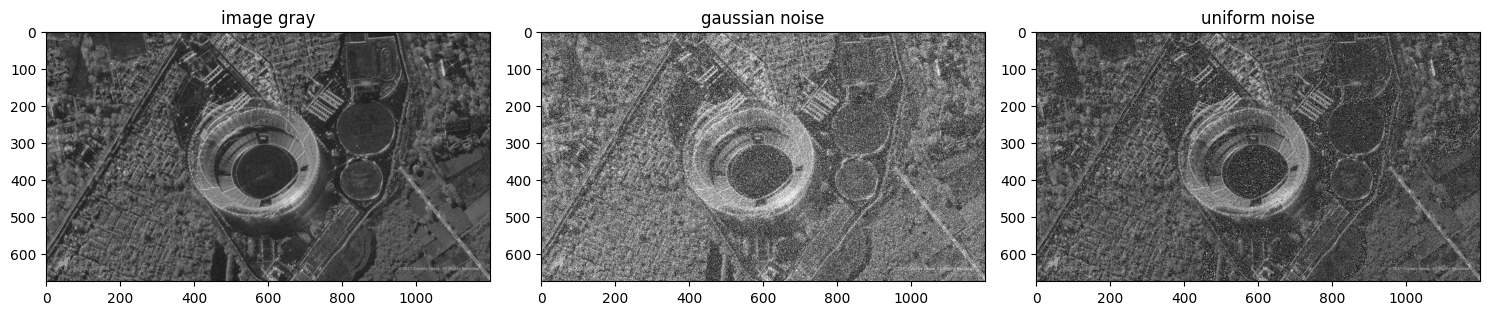

In [11]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

mean = 0
std = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, std)
noise_gauss_image = cv2.add(image_gray, noise_gauss)

low = -50
high = 50
noise_uniform = np.random.uniform(low, high, image_gray.shape).astype(np.uint8)
noise_uniform_image = np.clip(image_gray.astype(np.uint8) + noise_uniform, 0, 255).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_gray, cmap='gray'); axs[0].set_title('image gray')
axs[1].imshow(noise_gauss_image, cmap='gray'); axs[1].set_title('gaussian noise')
axs[2].imshow(noise_uniform_image, cmap='gray'); axs[2].set_title('uniform noise')
plt.tight_layout()
plt.show()

# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.

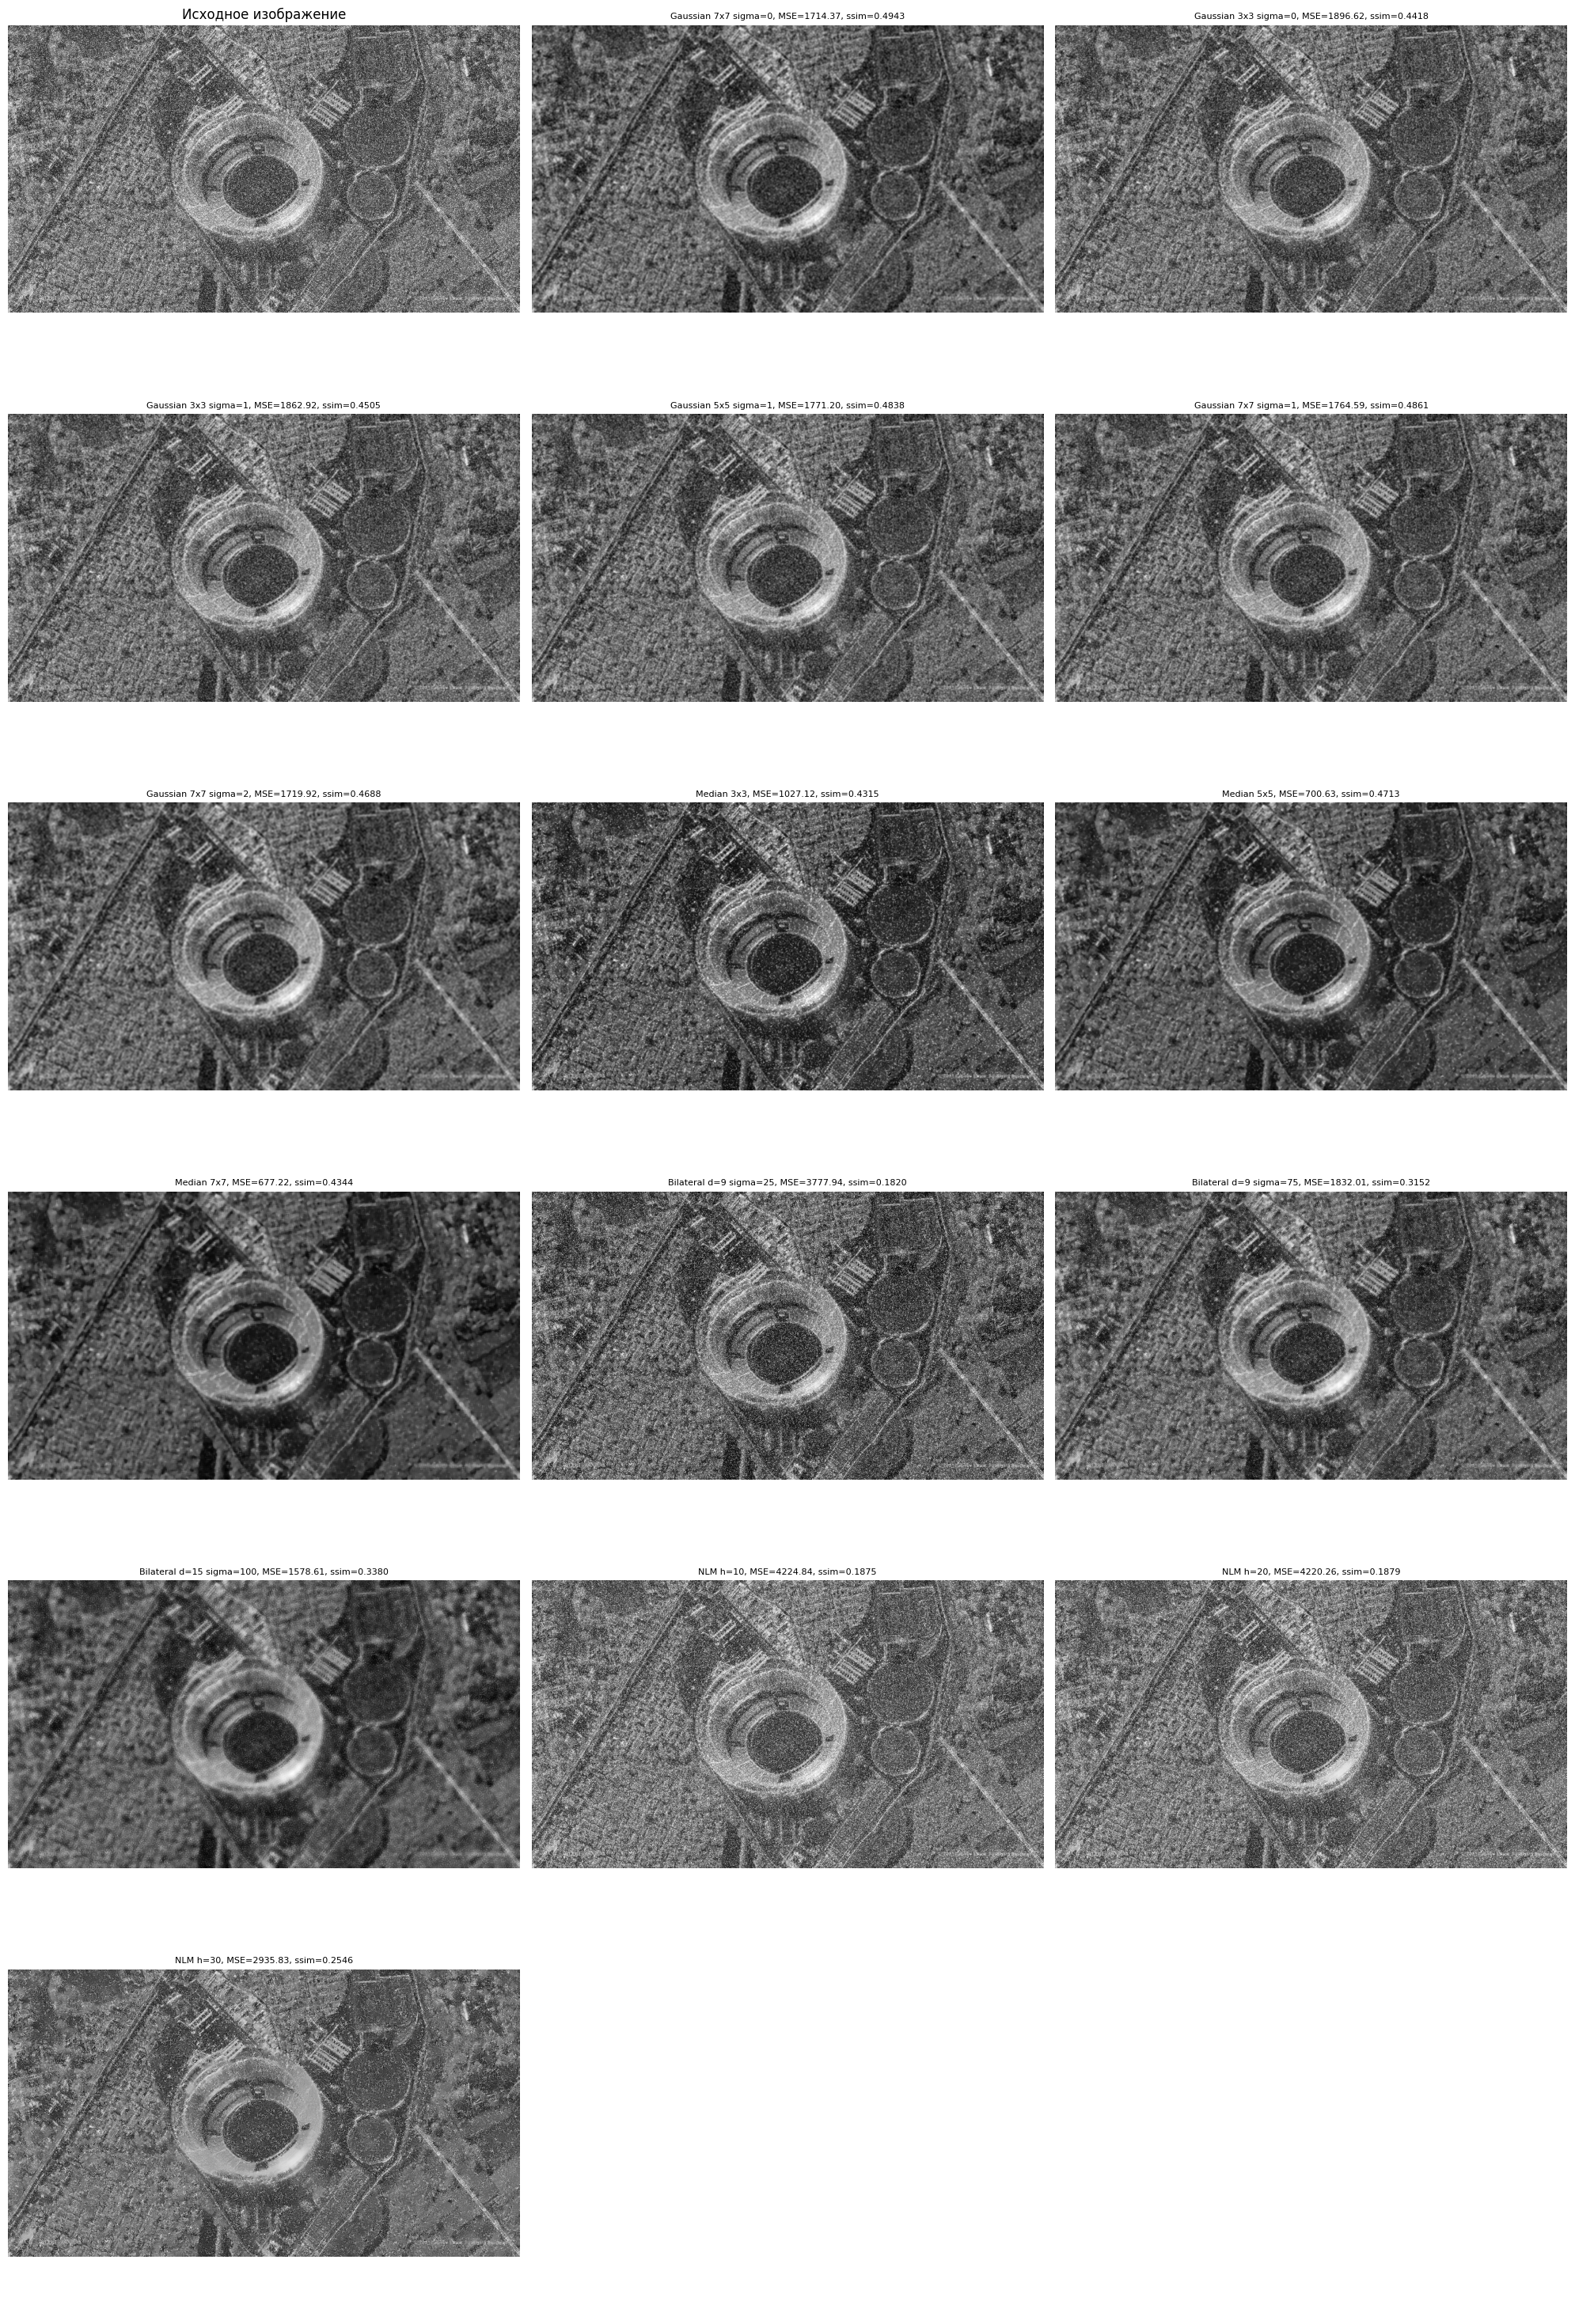

In [19]:
def filter_test_and_give_results(noisy_image, clean_image):
    filters_to_test = [
        ('Gaussian 7x7 sigma=0', cv2.GaussianBlur(noisy_image, (7, 7), 0)),
        ('Gaussian 3x3 sigma=0', cv2.GaussianBlur(noisy_image, (3, 3), 0)),

        ('Gaussian 3x3 sigma=1', cv2.GaussianBlur(noisy_image, (3, 3), 1)),
        ('Gaussian 5x5 sigma=1', cv2.GaussianBlur(noisy_image, (5, 5), 1)),
        ('Gaussian 7x7 sigma=1', cv2.GaussianBlur(noisy_image, (7, 7), 1)),

        ('Gaussian 7x7 sigma=2', cv2.GaussianBlur(noisy_image, (7, 7), 2)),
        
        ('Median 3x3', cv2.medianBlur(noisy_image, 3)),
        ('Median 5x5', cv2.medianBlur(noisy_image, 5)),
        ('Median 7x7', cv2.medianBlur(noisy_image, 7)),
        
        ('Bilateral d=9 sigma=25', cv2.bilateralFilter(noisy_image, 9, 25, 25)),
        ('Bilateral d=9 sigma=75', cv2.bilateralFilter(noisy_image, 9, 75, 75)),
        ('Bilateral d=15 sigma=100', cv2.bilateralFilter(noisy_image, 15, 100, 100)),
        
        ('NLM h=10', cv2.fastNlMeansDenoising(noisy_image, h=10)),
        ('NLM h=20', cv2.fastNlMeansDenoising(noisy_image, h=20)),
        ('NLM h=30', cv2.fastNlMeansDenoising(noisy_image, h=30))
    ]
    results = {}

    
    for filter_name, filtered_image in filters_to_test:
        mse = mean_squared_error(clean_image, filtered_image)
        ssim = structural_similarity(clean_image, filtered_image)
        
        results[filter_name] = {
            'image': filtered_image,
            'mse': mse,
            'ssim': ssim
        }
    return results
def plot_results(noisy_image, results):
    n_filters = len(results)
    n_cols = 3
    n_rows = (n_filters + n_cols) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    axes[0].imshow(noisy_image, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')
    
    for idx, (filter_name, result) in enumerate(results.items(), 1):
        if idx < len(axes):
            axes[idx].imshow(result['image'], cmap='gray')
            axes[idx].set_title(f'{filter_name}, MSE={result['mse']:.2f}, ssim={result['ssim']:.4f}', fontsize=8)
            axes[idx].axis('off')
    
    for idx in range(len(results) + 1, len(axes)):
        axes[idx].axis('off')
        
    plt.tight_layout()
    plt.show()
results = filter_test_and_give_results(noise_gauss_image, image_gray)
plot_results(noise_gauss_image, results)


# Выяснить, какой фильтр показал лучший результат фильтрации шума.

(np.float64(-0.5), np.float64(1199.5), np.float64(674.5), np.float64(-0.5))

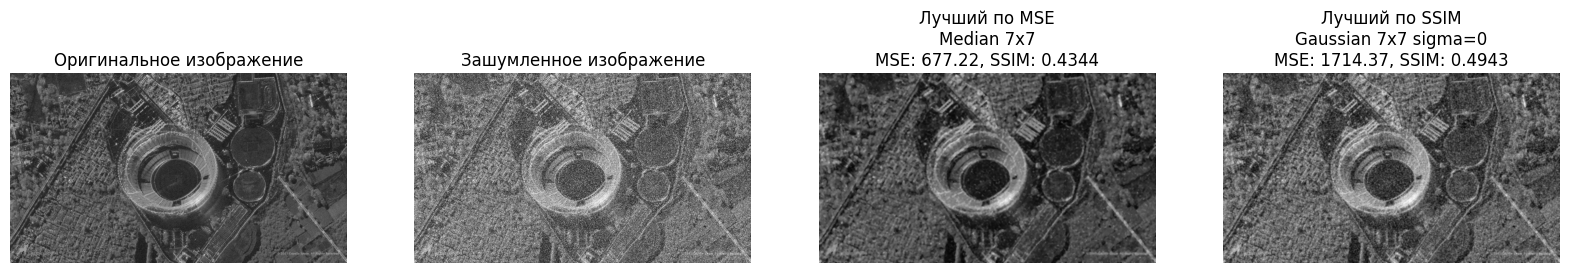

In [21]:
def find_best_filter_mse_ssim(results):
    best_filter_mse = None
    best_filter_msi = None
    
    for filter_name, result in results.items():
        mse = result['mse']
        ssim = result['ssim']
        
        if best_filter_mse is None or mse < best_filter_mse['mse']:
            best_filter_mse = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }

        elif mse == best_filter_mse['mse'] and ssim > best_filter_mse['ssim']:
            best_filter_mse = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }

        if best_filter_msi is None or ssim > best_filter_msi['ssim']:
            best_filter_msi = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }

        elif ssim == best_filter_msi['ssim'] and mse < best_filter_msi['mse']:
            best_filter_msi = {
                'name': filter_name,
                'image': result['image'],
                'mse': mse,
                'ssim': ssim
            }
    
    return [best_filter_mse, best_filter_msi]

best_result = find_best_filter_mse_ssim(results)

plt.figure(figsize=(20, 15))

plt.subplot(1, 4, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Оригинальное изображение')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(noise_gauss_image, cmap='gray')
plt.title('Зашумленное изображение')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(best_result[0]['image'], cmap='gray')
plt.title(f'Лучший по MSE\n{best_result[0]["name"]}\nMSE: {best_result[0]["mse"]:.2f}, SSIM: {best_result[0]["ssim"]:.4f}')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(best_result[1]['image'], cmap='gray')
plt.title(f'Лучший по SSIM\n{best_result[1]["name"]}\nMSE: {best_result[1]["mse"]:.2f}, SSIM: {best_result[1]["ssim"]:.4f}')
plt.axis('off')